<a href="https://colab.research.google.com/github/JoaoGranja/Data_Science_Bowl_2018/blob/main/DataScience_Bowl_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 # **Configuration and imports**

First thing I do is to import all modules we need for this project. I also use some configuration parameters to be used through the project

In this project I will be making use of the Keras library for creating our model and training it. I will also use Matplotlib and Seaborn for visualizing our dataset to gain a better understanding of the images we are going to be handling. Another important library to handle image data is Opencv.



In [12]:
# Generic Imports
import time
import gc
import os
import sys
import random
import warnings
import pickle
from math import ceil
from tqdm import tqdm
from itertools import chain

# data processing and visualization library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# image procesing library
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import cv2 

# tensorflow and keras for CNN model
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.datasets import cifar10
#from keras.utils import multi_gpu_model
from keras.preprocessing.image import Iterator, load_img, img_to_array

#-------------------------------------------------------------------------------------------------------------------------
# Set some configuration parameters
args = {}
args['seed'] = 42

#training arguments
args['batch_size'] = 32
args['epochs'] = 3
args['validation_split'] = 0.2

#model arguments
args['network'] = 'LeNet'

#optimizer arguments
args['optimizer'] = 'adam'
args['learning_rate'] = 0.001  
args['decay'] = 0.0001
args['loss'] = 'sparse_categorical_crossentropy'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

## Loading the dataset

In this project I will use the CIFAR10 dataset which is comprised of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class labels and their standard associated integer values are listed below. More information is available on [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html)

<ul>
<li> 0: airplane </li>
<li> 1: automobile </li>
<li> 2: bird </li>
<li> 3: cat </li>
<li> 4: deer </li>
<li> 5: dog </li>
<li> 6: frog </li>
<li> 7: horse </li>
<li> 8: ship </li>
<li> 9: truck </li>
</ul>

In [3]:
def unpickle(file):
    with open(file, 'rb') as data:
        dataset = pickle.load(data)
    return dataset

In [4]:
# load dataset using keras.dataset API
download_dataset = False
if download_dataset:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    dataset = {}
    dataset['x_train'], dataset['y_train'], dataset['x_test'], dataset['y_test'] = x_train, y_train, x_test, y_test
    with open('dataset/cifar10.pickle', 'wb') as output:
        pickle.dump(dataset, output)
else:
    dataset = unpickle('dataset/cifar10.pickle')
    #(x_train, y_train), (x_test, y_test) = (dataset['x_train'][:5000], dataset['y_train'][:5000]), (dataset['x_test'][:1000], dataset['y_test'][:1000])
    (x_train, y_train), (x_test, y_test) = (dataset['x_train'], dataset['y_train']), (dataset['x_test'], dataset['y_test'])



#Check train and test dataset shape
print("Train dataset: x={} y={}".format(x_train.shape, y_train.shape))
print("Test dataset: x={} y={}".format(x_test.shape, y_test.shape))

#Check number of classes and image shape
print("Image data shape =", x_train.shape[1:])
print("Number of classes =",  len(np.unique(y_train)))

class_names = {}
class_names[0] = 'airplane'
class_names[1] = 'automobile'
class_names[2] = 'bird'
class_names[3] = 'cat'
class_names[4] = 'deer'
class_names[5] = 'dog'
class_names[6] = 'frog'
class_names[7] = 'horse'
class_names[8] = 'ship'
class_names[9] = 'truck'

Train dataset: x=(50000, 32, 32, 3) y=(50000, 1)
Test dataset: x=(10000, 32, 32, 3) y=(10000, 1)
Image data shape = (32, 32, 3)
Number of classes = 10


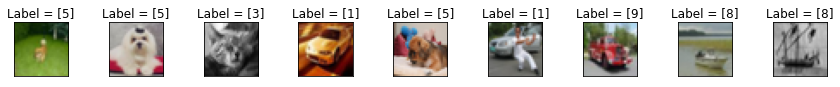

In [5]:
#Plot a random images and respective labels
n_images = 9

fig, axs = plt.subplots(1, n_images, figsize=(12, 12))
fig.tight_layout(pad=1.0)

        
# View the images
for i in range(n_images):
    index = random.randint(0, len(x_train))
    image = x_train[index].squeeze()

    axs[i].imshow(image)
    axs[i].set_title("Label = {0}".format(class_names[y_train[index]]))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)


Analyzing the images it is clear that the images resolution is small, actually 32x32 has few pixels and therefore can be a challenge for a model to classify correctly the object. Furthermore all image has the same size so it is not required to resize the input images.

# **Pre-processing the train and test dataset**

In [6]:
from aug.functional import transform_image, normalize_image


In [7]:
# Using simple data augmentation followed by normalization to the train dataset
x_train_norm = normalize_image(x_train)
y_train_ = y_train

# random data augmentation
data_aug_samples = 3
for i in range(data_aug_samples):
    x_train_norm = np.vstack((x_train_norm,normalize_image(transform_image(x_train))))
    y_train_ = np.vstack((y_train_,y_train))

#Check train dataset shape
print("Train dataset: x={} y={}".format(x_train_norm.shape, y_train_.shape))

# normalization of test dataset
x_test_norm = normalize_image(x_test)

# remove old datasets
del x_test, x_train, y_train
x_train, y_train, x_test = x_train_norm, y_train_, x_test_norm
del x_train_norm, y_train_, x_test_norm


Train dataset: x=(200000, 32, 32, 3) y=(200000, 1)


# **Optimizer**

Before training it is necessary to choose an optimizer which will be responsible to adjust model parameters in order to reduce the loss funcion

In [8]:
# Define an optimizer
if args['optimizer'] == 'rmsprop':
    optimizer = RMSprop(learning_rate=args['learning_rate'], decay=float(args['decay']))
elif args['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']))
elif args['optimizer'] == 'amsgrad':
    optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']), amsgrad=True)
elif args['optimizer'] == 'sgd':
    optimizer = SGD(learning_rate=args['learning_rate'], momentum=0.9, nesterov=True, decay=float(args['decay']))
else:
    optimizer = RMSprop(learning_rate=args['learning_rate'])

# **Model**

In this project, I will first use a simple CNN model following the LeNet architecture.

In [9]:
class ModelCheckpointMGPU(ModelCheckpoint):
    def __init__(self, original_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        self.original_model = original_model
        super().__init__(filepath, monitor, verbose, save_best_only, save_weights_only, mode, period)

    def on_epoch_end(self, epoch, logs=None):
        self.model = self.original_model
        super().on_epoch_end(epoch, logs)

# When pre-trained models are used, we can want to freeze some layers and train some final layers
def freeze_model(model, freeze_before_layer):
    if freeze_before_layer == "ALL":
        for l in model.layers:
            l.trainable = False
    else:
        freeze_before_layer_index = -1
        for i, l in enumerate(model.layers):
            if l.name == freeze_before_layer:
                freeze_before_layer_index = i
        for l in model.layers[:freeze_before_layer_index + 1]:
            l.trainable = False
            
def schedule_steps(epoch, steps):
    for step in steps:
        if step[1] > epoch:
            print("Setting learning rate to {}".format(step[0]))
            return step[0]
    print("Setting learning rate to {}".format(steps[-1][0]))
    return steps[-1][0]   

In [10]:
from models.model_factory import make_model

if 'multi_gpu' in args:
    with K.tf.device("/cpu:0"):
        model = make_model(args['network'], (32, 32, 3))
else:
    model = make_model(args['network'], (32, 32, 3), 10)
    
if 'weights' not in args:
    print('No weights passed, training from scratch')
else:
    weights_path = args['weights']
    print('Loading weights from {}'.format(weights_path))
    model.load_weights(weights_path, by_name=True)
    
#-----freeze_model(model, args['freeze_till_layer'])
model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 
model.summary()

No weights passed, training from scratch
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (Max

# **Training**

In [13]:
# Fit model

#----------------------------Model check points-------------------------------------#
args['models_dir'] = 'nn_models_checkpoints'
best_model_file = '{}/best_{}.h5'.format(args['models_dir'], args['network'])
last_model_file = '{}/last_{}.h5'.format(args['models_dir'], args['network'])


#----------------------------multi_gpu-------------------------------------#
#if 'multi_gpu' in args:
#        model = multi_gpu_model(model, len(gpus))

callbacks = [
        # Callback to reduce the learning rate once the plateau has been reached:
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=8,
            mode='auto',
            min_delta=0.001,
            cooldown=0,
            min_lr=1e-8
        ),
        # Callback to stop the training once no more improvements are recorded:
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,
            patience=16,
            mode='auto',
            restore_best_weights=True
        ),
        # Callback to log the graph, losses and metrics into TensorBoard:
        TensorBoard(log_dir="logs/{}".format(args['network'])
        ),
        # Callback to save the best and last model specifying the epoch and val-loss in the filename:
        ModelCheckpoint(filepath=last_model_file, 
            monitor='val_loss',
            verbose=1,
            mode='min',
            save_freq='epoch',
            save_best_only=False,
            save_weights_only=True
        ),
        ModelCheckpoint(filepath=best_model_file, 
            monitor='val_loss',
            verbose=1,
            mode='min',
            save_freq='epoch',
            save_best_only=True,
            save_weights_only=True)
    ]


# 
#----------------------------Model Fit-------------------------------------#
history = model.fit(x_train, y_train,
                    validation_split=args['validation_split'],
                    epochs=args['epochs'], 
                    batch_size=args['batch_size'], 
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/3
5000/5000 [==============================] - 509s 98ms/step - loss: 1.6691 - accuracy: 0.3749 - val_loss: 1.2185 - val_accuracy: 0.5649

Epoch 00001: saving model to nn_models_checkpoints/last_LeNet.h5

Epoch 00001: val_loss improved from inf to 1.21848, saving model to nn_models_checkpoints/best_LeNet.h5
Epoch 2/3
5000/5000 [==============================] - 420s 84ms/step - loss: 1.0948 - accuracy: 0.6108 - val_loss: 1.0438 - val_accuracy: 0.6313

Epoch 00002: saving model to nn_models_checkpoints/last_LeNet.h5

Epoch 00002: val_loss improved from 1.21848 to 1.04378, saving model to nn_models_checkpoints/best_LeNet.h5
Epoch 3/3
5000/5000 [==============================] - 425s 85ms/step - loss: 0.8997 - accuracy: 0.6812 - val_loss: 0.9780 - val_accuracy: 0.6560

Epoch 00003: saving model to nn_models_checkpoints/last_LeNet.h5

Epoch 00003: val_loss improved from 1.04378 to 0.97801, saving model to nn_models_checkpoints/best_LeNet.h5


# **Visualise Training Results**

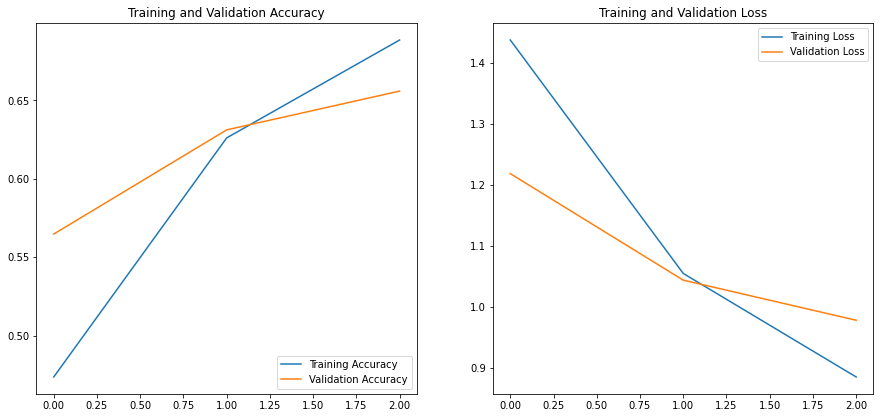

In [14]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(args['epochs'])

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    # save plot to file
    filename = "accuracy"
    plt.savefig(filename + '_plot.png')
    plt.show()
    plt.close()
    
summarize_diagnostics(history)


# **Evaluation**

Predict the object class for testing data

nn_models_checkpoints/last_LeNet.h5


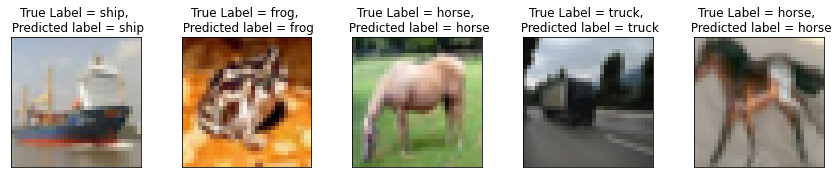

In [50]:
# Predict on train and test
import timeit
t0 = timeit.default_timer()

#Load last model parameters
print(last_model_file)
model.load_weights(last_model_file, by_name=True)

#Try out the model on an image from the test data:
n_images = 5
fig, axs = plt.subplots(1, n_images, figsize=(12, 12))
fig.tight_layout(pad=1.0)

        
# View the images
for i in range(n_images):
    index = random.randint(0, len(x_test))
    image = x_test[index].squeeze()
    true_index = int(y_test[index])

    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)
    
    image = np.add(image*128,128).astype(int)
    axs[i].imshow(image)
    axs[i].set_title("True Label = {0}, \n Predicted label = {1}".format(class_names[true_index], class_names[predicted_index]))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)



In [51]:
# Evaluate model from traning and testing dataset

_, acc = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy = {}".format(acc))

_, acc = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy = {}".format(acc))

Training Accuracy = 0.7028499841690063
Testing Accuracy = 0.7092999815940857
